In [1]:
import distl
import numpy as np

Unless `cache_sample=False` is passed, calling `sample` will cache the results so that successive calls to `pdf`, `logpdf`, `cdf`, `logcdf`, etc are computed based on the latest sampled values.  This avoids the need to do the following:

```
samples = dist.sample()
print(samples)
dist.pdf(samples)
```

Although this wouldn't exactly be difficult for a simple univariate and even multivariate cases... things get a lot more complicated with MultivariateSlice, Composite, and DistributionCollections.  `distl` allows for tracking the samples of the underlying distributions, but it is important to understand when covariances are respected and when they're ignored.

# Univariate Distributions

In [2]:
g = distl.gaussian(10, 2)

In [3]:
g.sample()

9.900940302116243

In [4]:
g.cached_sample

9.900940302116243

In [5]:
g.pdf()

0.1992266183043953

If passing `size` to `sample` then the cached values will keep that shape and `pdf` etc will return an array with one entry per sample.

In [6]:
g.sample(size=2)

array([6.10428511, 8.83604573])

In [7]:
g.cached_sample

array([6.10428511, 8.83604573])

In [8]:
g.pdf()

array([0.02992204, 0.16839643])

Of course at any point a value can be passed to any of this methods to override computing at the cached sample values.

In [9]:
g.pdf(10.5)

0.19333405840142465

# Multivariate Distributions

Multivariate distributions essentially act the same as Univariate distributions except the returned samples have an extra dimension.  The provided covariances are always respected - calls to `pdf` etc return the probability of drawing the provided *set* of values from the multivariate distribution.

In [10]:
mvg = distl.mvgaussian([5,10, 12], 
                       np.array([[ 2,  1, -1], 
                                 [ 1,  2,  1], 
                                 [-1,  1,  2]]),
                       allow_singular=True,
                       labels=['a', 'b', 'c'])

In [11]:
mvg.sample()

array([ 3.19921555,  7.93923632, 11.74002076])

In [12]:
mvg.cached_sample.shape[-1], mvg.ndimensions

(3, 3)

For multivariates, `pdf` is the probability density of drawing the set of values for each dimension.

In [13]:
mvg.pdf()

0.01505543608374843

If passing `size` to `sample`, then the samples will be of shape (`size`, `ndimensions`) and the `pdf` call will return an array with length `size`.

In [14]:
mvg.sample(size=2)

array([[ 3.35510368,  9.09194424, 12.73684056],
       [ 4.02721431,  8.27476347, 11.24754916]])

In [15]:
mvg.cached_sample

array([[ 3.35510368,  9.09194424, 12.73684056],
       [ 4.02721431,  8.27476347, 11.24754916]])

In [16]:
mvg.pdf()

array([0.02690742, 0.02510608])

# MultivariateSlice Distributions

It is important to remember that MultivariateSlices act as Univariate distributions for all cases except sampling - in which case the covariances can be remembered.  This allows for a lot of convenience functionality such as plotting the projected pdf.  That said - since the underlying distribution is a multivariate, the multivariate probabilities can still be manually accessed.

In [17]:
mvg_a = mvg.slice('a')

In [18]:
mvg_a.sample()

5.1774427052571195

In [19]:
mvg_a.cached_sample

array([ 3.35510368,  9.09194424, 12.73684056])

In [20]:
mvg_a.multivariate.cached_sample

array([[ 3.35510368,  9.09194424, 12.73684056],
       [ 4.02721431,  8.27476347, 11.24754916]])

A call to `pdf` will expose the `pdf` of the flattened univariate representation of this slice given `cached_sample` above.

In [21]:
mvg_a.pdf()

array([1.43426424e-01, 4.28980488e-03, 8.93962067e-08])

Note the important distinction between the line above and the one below.  Below we are accessing the probability of drawing the set of drawn values (from `mvg_a.multivariate.cached_sample`).

In [22]:
mvg_a.multivariate.pdf()

array([0.02690742, 0.02510608])

As in the other cases, this same logic applies when passing `size` to `sample`.

In [23]:
mvg_a.sample(size=2)

array([5.76028248, 6.74748488])

In [24]:
mvg_a.cached_sample

array([ 3.35510368,  9.09194424, 12.73684056])

In [25]:
mvg_a.pdf()

array([1.43426424e-01, 4.28980488e-03, 8.93962067e-08])

# Composite Distributions

Similarly to MultivariateSlices, Composite distributions also expose the univariate pdfs after any math operations, but use the underlying "children" distributions when sampling to respect any covariances.

In [26]:
g = distl.gaussian(10, 2)
u = distl.uniform(1, 3)
c = g * u

In [27]:
c.sample()

33.44445139761177

In [28]:
c.cached_sample

33.44445139761177

As with MultivariateSlices, `pdf` here is exposing the probability of drawing `cached_sample` (or the provided value) from the combined/flattened distribution.

In [29]:
c.pdf()

0.011540154840759452

where the pdf is being determined from the stored (interpolated) flattened pdf function.

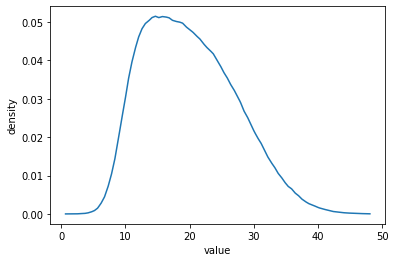

In [30]:
out = c.plot_pdf(show=True)

However, the underlying drawn values of the children distributions are still accessible.  Here we can see the values for the gaussian and uniform distributions that were drawn before applying multiplication.

In [31]:
c.cached_sample_children

[11.684825206551611, 2.8622123828484547]

In [32]:
c.cached_sample_children[0] * c.cached_sample_children[1]

33.44445139761177

If we wanted to, we could determine the individual probabilities of drawing these two components.

In [33]:
c.dist1.pdf(c.cached_sample_children[0]), c.dist2.pdf(c.cached_sample_children[1])

(0.1398877154261344, 0.5)

The probability of drawing this *set* of values from the children would then be the product (or the sum in the case of `logpdf`).

In [34]:
c.dist1.pdf(c.cached_sample_children[0]) * c.dist2.pdf(c.cached_sample_children[1])

0.0699438577130672

As you probably expect by now, the same logic holds when passing `size` to `sample`.

In [35]:
c.sample(size=2)

array([33.4444514 , 18.61904463])

In [36]:
c.cached_sample

array([33.4444514 , 18.61904463])

In [37]:
c.cached_sample_children

[array([11.68482521,  8.97531451]), array([2.86221238, 2.07447267])]

# Distribution Collection

In [38]:
ds = distl.DistributionCollection(g, mvg_a, c)

In [39]:
ds

In [40]:
ds.sample()

TypeError: sample() got an unexpected keyword argument 'seed'

For collections, `cached_sample` refers to the passed `distributions`...

In [41]:
ds.cached_sample

In [ ]:
ds.distributions

... whereas `cached_samples_unpacked` refers to the unpacked list of all underlying distributions (i.e. composite distributions are broken down into their subcomponents so that all the actual drawn values can be recorded to track covariances).

In [ ]:
ds.cached_sample_unpacked

In [ ]:
ds.distributions_unpacked